In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

# Estatística e análise
import scipy.stats as stats
from scipy.stats import fisher_exact, linregress
from itertools import combinations

# Geoprocessamento
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
from geobr import read_state

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Otimização
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Conexão com banco de dados
import psycopg2

# Configurações e ajustes
import warnings
import unicodedata
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
# Ocultar warnings
warnings.filterwarnings("ignore")

# Configurações de exibição
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

import geopandas as gpd
from shapely import wkt

# Importando as bibliotecas necessárias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/home/deboragomes/.local/share/virtualenvs/debora-a-xJ3oPA/lib/python3.10/site-packages/geopandas/_compat.py:154: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_103192/2475754626.py:19: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


# base_querida_gui

| **Tipo do Evento**   | **Significado** |
|----------------------|----------------|
| **created**         | O frete foi criado (`freight_created`). |
| **changed**         | O frete teve alguma alteração (`freight_change`). |
| **postponed**       | A data de início do frete (`start_at`) foi alterada (`start_at_change`). |
| **canceled_by_user** | O frete foi cancelado por um usuário normal (`App\Models\User`). |
| **canceled_by_company_multilevel** | O frete foi cancelado por uma empresa multilevel (`App\Models\CompanyMultilevel`). |
| **expired**         | O frete passou da data de início sem um motorista (`has_driver`) e não foi cancelado antes disso. |
| **success**         | O frete teve a verificação de seguro (`check_insurance`) sem um evento de remoção de motorista (`removed_driver`). |

In [2]:
base_querida_gui = pd.read_csv("data/base_querida_gui.csv")
base_querida_gui = base_querida_gui.sort_values(by=['contract_id', "data_evento"])

# Criar um dicionário de mapeamento para os novos nomes
mapeamento_eventos = {
    'created': 'criado',
    'changed': 'alterado',
    'postponed': 'postergado',
    'expired': 'expirado',
    'canceled': 'cancelado',
    'canceled_by_user': 'cancelado',
    'canceled_by_company_multilevel': 'cancelado'
}

# Aplicar a substituição na coluna tipo_evento
base_querida_gui['tipo_evento'] = base_querida_gui['tipo_evento'].replace(mapeamento_eventos)

base_querida_gui.head(3)

,contract_id,tipo_evento,data_evento,mes,criacao_contrato,tipo_contrato,sequencia_eventos
25211,91462,criado,2024-07-01 00:27:58.000,2024-07-01 00:00:00.000,2024-07-01 00:27:58.000,Coleta/Entrega,1
82775,91462,expirado,2024-07-01 07:30:00.000,2024-07-01 00:00:00.000,2024-07-01 00:27:58.000,Coleta/Entrega,1
117573,91462,success,2024-07-01 09:04:46.000,2024-07-01 00:00:00.000,2024-07-01 00:27:58.000,Coleta/Entrega,1


In [3]:
base_querida_gui.loc[base_querida_gui.contract_id == 81196]

,contract_id,tipo_evento,data_evento,mes,criacao_contrato,tipo_contrato,sequencia_eventos


In [4]:
# contagem_unica
contagem_unica = base_querida_gui.groupby('tipo_evento')['contract_id'].nunique().reset_index()
contagem_unica.rename(columns={'contract_id': 'num_contracts_unicos'}, inplace=True)
contagem_unica

,tipo_evento,num_contracts_unicos
0,alterado,8339
1,cancelado,11554
2,criado,57564
3,expirado,12527
4,postergado,11440
5,success,47810


# user_working_freights

time_to_work: tempo entre contrato entrar para o falcon e o início do contrato
time_of_work: tempo que o falcon trabalhou no contrato

In [5]:
# falcon
conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()

cursor.execute(f"""

    SELECT 
        freight_id,
        created_at,
        updated_at,
        freight_status,
        is_working,
        selected_driver,
        time_to_work,
        time_of_work,
        driver_invites,
        total_visits,	
        total_candidatures      
    FROM user_working_freights
""")


falcon = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]

falcon = pd.DataFrame(falcon, columns=colnames)

cursor.close()
conn.close()

falcon= falcon.sort_values(by=['freight_id', 'created_at'])
falcon['mes'] = pd.to_datetime(falcon['created_at'])

# tirar os freight_id 10047, 10299 e 12246 que conforme tabela freights ocorreram em 2022
freights_para_remover = [10047, 10299, 12246]
falcon = falcon[~falcon['freight_id'].isin(freights_para_remover)]
falcon['mes'] = pd.to_datetime(falcon['created_at']).dt.to_period('M').dt.to_timestamp()

falcon = falcon.loc[falcon.is_working == False]
falcon = falcon.drop(columns=['is_working'])

# tirar o mês de dezembro por ser um mes atípio (Tiago)
falcon = falcon[falcon['mes'].dt.month != 12]
falcon = falcon.fillna(0)


falcon.head(3)

,freight_id,created_at,updated_at,freight_status,selected_driver,time_to_work,time_of_work,driver_invites,total_visits,total_candidatures,mes
20304,18859,2024-10-31 09:11:03,2024-10-31 17:30:08,Cancelada,0.00,856901,499.00,0.00,0.00,0.00,2024-10-01
514,81196,2024-07-06 11:57:53,2024-07-06 11:58:04,Aguardando,0.00,2612,0.00,50.00,0.00,0.00,2024-07-01
641,84431,2024-07-08 10:24:53,2024-07-08 18:30:05,Aguardando,0.00,2705,485.00,62.00,0.00,0.00,2024-07-01


In [6]:
# contratos_falcon
contratos_falcon = falcon.groupby(['mes','freight_id']).agg(
    first_created_at_falcon=('created_at', 'min'),
    last_updated_at_falcon =('updated_at', 'max'),
    soma_time_of_work=('time_of_work', 'sum'),
    motorista_selecionado=('selected_driver', 'sum'),
    qt_total_convites = ('driver_invites', 'sum'),
    qt_total_visitas=('total_visits', 'sum'),
    qt_total_candidaturas=('total_candidatures', 'sum')
).reset_index()

contratos_falcon['motorista_selecionado'] = contratos_falcon['motorista_selecionado'].apply(lambda x: 'nao' if x == 0 else 'sim')
contratos_falcon['diff_hours_falcon'] = (contratos_falcon['last_updated_at_falcon'] - contratos_falcon['first_created_at_falcon']).dt.total_seconds() / 3600

# Converter 'soma_time_of_work' de minutos para horas
contratos_falcon["soma_horas_trabalhadas"] = (contratos_falcon["soma_time_of_work"] / 60).round(2)


contratos_falcon.head(3)

,mes,freight_id,first_created_at_falcon,last_updated_at_falcon,soma_time_of_work,motorista_selecionado,qt_total_convites,qt_total_visitas,qt_total_candidaturas,diff_hours_falcon,soma_horas_trabalhadas
0,2024-07-01,81196,2024-07-06 11:57:53,2024-07-06 11:58:04,0.00,nao,50.00,0.00,0.00,0.00,0.00
1,2024-07-01,84431,2024-07-08 10:24:53,2024-07-08 18:30:05,485.00,nao,62.00,0.00,0.00,8.09,8.08
2,2024-07-01,87120,2024-07-05 18:15:21,2024-07-08 04:30:08,1472.00,nao,928.00,0.00,0.00,58.25,24.53


In [7]:
# placeholders (pegando os contratos que falcon atuou para as próximas queries)

# Converter os valores para tipos nativos do Python (int)
freight_ids_filtrados = [int(fid) for fid in falcon['freight_id'].unique()]
# Criar placeholders (%s, %s, %s...) para a query SQL
placeholders = ", ".join(["%s"] * len(freight_ids_filtrados))

In [8]:
contratos_falcon.freight_id.nunique()

17945

# freight_histories

In [9]:
# freight_histories 

# Conectar ao banco de dados
conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()


# Criar a query parametrizada
query = f"""
    SELECT 
        freight_id,
        created_at,
        updated_at,
        old_value,
        new_value, 
        key
    FROM freight_histories
    WHERE freight_histories.created_at > '2024-06-30'   
    AND freight_histories.freight_id IN ({placeholders})
"""

cursor.execute(query, tuple(freight_ids_filtrados))
freight_histories = cursor.fetchall()

colnames = [desc[0] for desc in cursor.description]

freight_histories = pd.DataFrame(freight_histories, columns=colnames)

cursor.close()
conn.close()

freight_histories= freight_histories.sort_values(by=['created_at','freight_id'])

# Garantir que old_value e new_value são datetime
#freight_histories['old_value'] = pd.to_datetime(freight_histories['old_value'], errors='coerce')
#freight_histories['new_value'] = pd.to_datetime(freight_histories['new_value'], errors='coerce')


#freight_histories['diff_hours'] = (freight_histories['new_value'] - freight_histories['old_value']).dt.total_seconds() / 3600

# freight_histories = freight_histories.loc[freight_histories.diff_hours > 0]

freight_histories.head(3)


,freight_id,created_at,updated_at,old_value,new_value,key
1114,91112,2024-06-30 08:37:36,2024-06-30 08:37:36,0,100,status
284,89917,2024-06-30 09:57:10,2024-06-30 09:57:10,0,100,status
283,89917,2024-06-30 09:58:00,2024-06-30 09:58:00,100,0,status


In [10]:
# periodo_falcon

resumo_falcon = contratos_falcon[['freight_id',	'motorista_selecionado','first_created_at_falcon',	'last_updated_at_falcon']]
periodo_falcon = resumo_falcon.merge(freight_histories, on='freight_id', how='left')


def classificar_falcon(row):
    if row['updated_at'] < row['first_created_at_falcon']:
        return 'antes'
    elif row['created_at'] > row['last_updated_at_falcon']:
        return 'apos'
    else:
        return 'durante'
periodo_falcon['alteracao_contrato'] = periodo_falcon.apply(classificar_falcon, axis=1)

periodo_falcon.head(3)

,freight_id,motorista_selecionado,first_created_at_falcon,last_updated_at_falcon,created_at,updated_at,old_value,new_value,key,alteracao_contrato
0,81196,nao,2024-07-06 11:57:53,2024-07-06 11:58:04,2024-07-04 09:05:33,2024-07-04 09:05:33,3,1,contract_days,antes
1,81196,nao,2024-07-06 11:57:53,2024-07-06 11:58:04,2024-07-04 09:05:33,2024-07-04 09:05:33,30532,10177,px_commission,antes
2,81196,nao,2024-07-06 11:57:53,2024-07-06 11:58:04,2024-07-04 09:05:33,2024-07-04 09:05:33,2024-07-01 07:30:00,2024-07-08 07:30:00,start_at,antes


# contagem_alteracoes

In [11]:
# contagem_alteracoes
freight_alteracoes = periodo_falcon.groupby(['freight_id','motorista_selecionado','alteracao_contrato']).agg(qt_alteracaoes = ('key','count')).reset_index()

freight_alteracoes= freight_alteracoes.sort_values(by=['freight_id'])

# Transformar os valores da coluna 'alteracao_contrato' em colunas e os valores de 'qt_alteracoes' como linhas
contagem_alteracoes = freight_alteracoes.pivot(index=['freight_id','motorista_selecionado'], columns='alteracao_contrato', values='qt_alteracaoes')

contagem_alteracoes = contagem_alteracoes.fillna(0).astype(int)

contagem_alteracoes.reset_index(inplace=True)
contagem_alteracoes = contagem_alteracoes[['freight_id','motorista_selecionado', 'antes','durante']]

contagem_alteracoes['total'] = contagem_alteracoes['antes']+contagem_alteracoes['durante']

contagem_alteracoes.to_csv('contagem_alteracoes.csv', index=False)
contagem_alteracoes.head(3)

alteracao_contrato,freight_id,motorista_selecionado,antes,durante,total
0,18859,nao,0,0,0
1,81196,nao,7,0,7
2,84431,nao,10,0,10


# todos_contratos

In [12]:
# todos_contratos
conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()

cursor.execute(f"""

    SELECT 
        f.type,
        public.freights_type(f.type) AS de_type,
        f.status,
        public.freights_status(f.status) AS de_status,
        CASE 
            WHEN f.status = 900 THEN 'sim'
            ELSE 'nao'
        END AS foi_cancelada, 
        f.start_at,
        f.id AS freight_id,
        f.vehicle_id,
        v.name AS vehicle,  
        f.price / 100 AS price,
        f.contract_days,
        f.company_id,
        ca.state_id,
        s.uf,
        CASE 
            WHEN uwf.freight_id IS NOT NULL THEN 'sim'
            ELSE 'nao'
        END AS atuacao_falcon
        FROM freights f
    LEFT JOIN (
        SELECT DISTINCT freight_id
        FROM user_working_freights
    ) uwf ON uwf.freight_id = f.id
    LEFT JOIN companies c ON c.id = f.company_id
    LEFT JOIN vehicles v ON f.vehicle_id = v.id  
    LEFT JOIN company_addresses ca ON ca.id = f.origin
    LEFT JOIN public.states s ON ca.state_id = s.id -- Join com a tabela states
    WHERE f.start_at >= '2024-07-01'
      AND f.company_id NOT IN (
          SELECT id 
          FROM companies 
          WHERE company_multitenancy_id = 5
      )
    ORDER BY f.start_at ASC;
""")


todos_contratos = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
todos_contratos = pd.DataFrame(todos_contratos, columns=colnames)

cursor.close()
conn.close()

todos_contratos['mes'] = pd.to_datetime(todos_contratos['start_at']).dt.to_period('M').dt.to_timestamp()

todos_contratos['vehicle'] = todos_contratos['vehicle'].str.replace(r'^Carreta.*', 'Carreta', regex=True)
todos_contratos['vehicle'] = todos_contratos['vehicle'].str.replace(r'^Manobrista.*', 'Manobrista', regex=True)
todos_contratos['vehicle'] = todos_contratos['vehicle'].str.replace(r'^Truck.*', 'Truck', regex=True)

#contratos = contratos[['mes', 'categoria', 'foi_cancelada', 'atuacao_falcon', 'company_descricao','freight_id', 'price','contract_days','company_id','meso', 'estado']]

todos_contratos = todos_contratos.loc[todos_contratos.mes < '2025-03-01']
todos_contratos = todos_contratos.sort_values(by=['freight_id'])
todos_contratos = todos_contratos[['mes','atuacao_falcon','start_at', 'uf','freight_id','de_type','de_status','foi_cancelada','vehicle','price', 'contract_days']]

todos_contratos.to_csv('todos_contratos.csv', index=False)
todos_contratos

,mes,atuacao_falcon,start_at,uf,freight_id,de_type,de_status,foi_cancelada,vehicle,price,contract_days
97,2024-07-01,nao,2024-07-01 07:00:00,MG,73565,Diária,Cancelada,sim,Rodotrem,1700,5
1344,2024-07-01,sim,2024-07-09 07:30:00,SC,81196,Diária,Finalizada,nao,Carreta,8992,28
1153,2024-07-01,nao,2024-07-08 07:30:00,ES,84429,Coleta/Entrega,Finalizada,nao,Truck,1150,5
1508,2024-07-01,sim,2024-07-10 07:30:00,ES,84431,Coleta/Entrega,Cancelada,sim,Truck,690,3
1154,2024-07-01,nao,2024-07-08 07:30:00,ES,84432,Coleta/Entrega,Finalizada,nao,Truck,1150,5
...,...,...,...,...,...,...,...,...,...,...,...
46740,2025-02-01,nao,2025-02-28 10:30:00,PR,146519,Diária,Finalizada,nao,Carreta,2211,7
46762,2025-02-01,nao,2025-02-28 13:00:00,SP,146531,Diária,Esperando NF,nao,Carreta,4880,16
47008,2025-02-01,nao,2025-02-28 23:30:00,SP,146533,Diária,Carregado,nao,Carreta,7440,20
47010,2025-02-01,nao,2025-02-28 23:30:00,SP,146535,Diária,Carregado,nao,Carreta,7440,20


In [13]:
# contratos

conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()

freight_ids_filtrados = [int(fid) for fid in falcon['freight_id'].unique()]

if freight_ids_filtrados:
    placeholders = ", ".join(["%s"] * len(freight_ids_filtrados))

query = f"""
SELECT 
    f.type,
    public.freights_type(f.type) AS de_type,
    CASE 
        WHEN f.status = 900 THEN 'sim'
        ELSE 'nao'
    END AS foi_cancelada, 
    f.id AS freight_id,
    f.start_at, 
    f.vehicle_id,
    v.name AS vehicle,  
    f.price / 100 AS price,
    f.contract_days,
    f.status,
    public.freights_status(f.status) AS de_status,
    f.status,   
    ca.state_id,
    s.uf
FROM freights f
LEFT JOIN vehicles v ON f.vehicle_id = v.id  
LEFT JOIN company_addresses ca ON ca.id = f.origin
LEFT JOIN public.states s ON ca.state_id = s.id -- Join com a tabela states
WHERE f.id IN ({placeholders})
AND  f.start_at >= '2024-07-01'
AND f.start_at < CURRENT_DATE
AND f.company_id NOT IN (
      SELECT id 
      FROM companies 
      WHERE company_multitenancy_id = 5
);
    
"""

cursor.execute(query, tuple(freight_ids_filtrados))

contratos = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
contratos = pd.DataFrame(contratos, columns=colnames)

cursor.close()
conn.close()


contratos['vehicle'] = contratos['vehicle'].str.replace(r'^Carreta.*', 'Carreta', regex=True)
contratos['vehicle'] = contratos['vehicle'].str.replace(r'^Manobrista.*', 'Manobrista', regex=True)
contratos['vehicle'] = contratos['vehicle'].str.replace(r'^Truck.*', 'Truck', regex=True)

contratos['mes'] = pd.to_datetime(contratos['start_at']).dt.to_period('M').dt.to_timestamp()
contratos = contratos.sort_values(by=['freight_id'])
contratos = contratos[['mes','start_at', 'uf','freight_id','de_type','de_status','vehicle','price', 'contract_days']]

contratos.head(3)

,mes,start_at,uf,freight_id,de_type,de_status,vehicle,price,contract_days
254,2024-07-01,2024-07-09 07:30:00,SC,81196,Diária,Finalizada,Carreta,8992,28
323,2024-07-01,2024-07-10 07:30:00,ES,84431,Coleta/Entrega,Cancelada,Truck,690,3
187,2024-07-01,2024-07-08 08:00:00,PR,87120,Diária,Cancelada,Carreta,8400,30


# BASE

In [28]:
contratos_resumo = contratos[['mes','uf','freight_id','de_type','de_status','vehicle',	'price',	'contract_days']]

base = contratos_resumo.merge(contratos_falcon , on=['mes', 'freight_id'], how='inner')

base = base.loc[base.mes != '2024-06-01']
base = base.loc[base.mes != '2024-12-01']

colunas_para_inteiro = ['qt_total_visitas','qt_total_candidaturas','qt_total_convites']
base[colunas_para_inteiro] = base[colunas_para_inteiro].astype(int)

base["vehicle"].fillna("Nao informado", inplace=True)

# Remover a coluna 'soma_time_of_work'
base.drop(columns=["soma_time_of_work"], inplace=True)

# Converter 'motorista_selecionado' para valores numéricos
base["motorista_selecionado"] = base["motorista_selecionado"].map({"sim": 1, "nao": 0})

# Arredondar 'diff_hours_falcon' para uma casa decimal
base["diff_hours_falcon"] = base["diff_hours_falcon"].round(2)

base = base[['mes', 'uf', 'freight_id', 'de_type', 'de_status', 'vehicle', 'price',
       'contract_days',  'diff_hours_falcon',
       'soma_horas_trabalhadas', 'qt_total_convites',
       'qt_total_visitas', 'qt_total_candidaturas','motorista_selecionado']]

base = base.loc[base.contract_days > 0]
base.head(3)


,mes,uf,freight_id,de_type,de_status,vehicle,price,contract_days,diff_hours_falcon,soma_horas_trabalhadas,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado
0,2024-07-01,SC,81196,Diária,Finalizada,Carreta,8992,28,0.00,0.00,50,0,0,0
1,2024-07-01,ES,84431,Coleta/Entrega,Cancelada,Truck,690,3,8.09,8.08,62,0,0,0
2,2024-07-01,PR,87120,Diária,Cancelada,Carreta,8400,30,58.25,24.53,928,0,0,0


In [ ]:
# 
base_nula = base[
    (base['diff_hours_falcon'] == 0) &
    (base['soma_horas_trabalhadas'] == 0) &
    (base['qt_total_convites'] == 0) &
    (base['qt_total_visitas'] == 0) &
    (base['qt_total_candidaturas'] == 0) &
    (base['motorista_selecionado'] == 0)
]
print(f'Eliminando {base_nula.shape[0]} contratos com atividade nula do time Falcon')


CONFERERIR SE POSSO FAZER ISSO:

SE O TIME FALCON NÃO POSSUI SOMA HORAS TRABALHADAS NEM TEM DIFF_HOURS, É PQ ELE NÃO ATUOU DE FATO NO CONTRATO. 

In [29]:
base = base[~((base['diff_hours_falcon'] == 0) &(base['soma_horas_trabalhadas'] == 0) )]
base.head(3)

,mes,uf,freight_id,de_type,de_status,vehicle,price,contract_days,diff_hours_falcon,soma_horas_trabalhadas,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado
1,2024-07-01,ES,84431,Coleta/Entrega,Cancelada,Truck,690,3,8.09,8.08,62,0,0,0
2,2024-07-01,PR,87120,Diária,Cancelada,Carreta,8400,30,58.25,24.53,928,0,0,0
3,2024-07-01,SP,88812,Coleta/Entrega,Cancelada,Vanderleia,2800,10,8.15,8.13,21,640,14,0


In [30]:
base.freight_id.nunique()

13829

## **1️⃣ Exploração Inicial e Limpeza dos Dados**

1. **Tratar valores nulos** (caso necessário).  
2. **Converter variáveis categóricas e booleanas** (exemplo: `motorista_selecionado` → 0 e 1).  
3. **Avaliar a distribuição, dispersão e medidas estatísticas dos dados**
3. **Remover outliers** nos dados originais para evitar distorções.  
4. **Analisar a correlação entre `soma_time_of_work` e `diff_hours_falcon`**

In [31]:
base.to_csv('base.csv', index=False)
base.head(3)

,mes,uf,freight_id,de_type,de_status,vehicle,price,contract_days,diff_hours_falcon,soma_horas_trabalhadas,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado
1,2024-07-01,ES,84431,Coleta/Entrega,Cancelada,Truck,690,3,8.09,8.08,62,0,0,0
2,2024-07-01,PR,87120,Diária,Cancelada,Carreta,8400,30,58.25,24.53,928,0,0,0
3,2024-07-01,SP,88812,Coleta/Entrega,Cancelada,Vanderleia,2800,10,8.15,8.13,21,640,14,0


In [32]:
## contratos_incosistentes: o tempo de horas trabalhadas é superior ao tempo de inicio e termino de atuação do falcon
contratos_inconsistentes = base[base['diff_hours_falcon'] < base['soma_horas_trabalhadas']]
print(contratos_inconsistentes.shape[0])
contratos_inconsistentes.head(3)

1531


,mes,uf,freight_id,de_type,de_status,vehicle,price,contract_days,diff_hours_falcon,soma_horas_trabalhadas,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado
7,2024-07-01,SP,89917,Diária,Finalizada,Carreta,9240,33,8.38,15.30,191,0,0,0
14,2024-07-01,SP,90506,Coleta/Entrega,Finalizada,Truck,3450,15,8.55,18.60,186,0,0,0
39,2024-07-01,SP,91790,Coleta/Entrega,Finalizada,Truck,2990,13,8.41,16.73,36,622,20,1


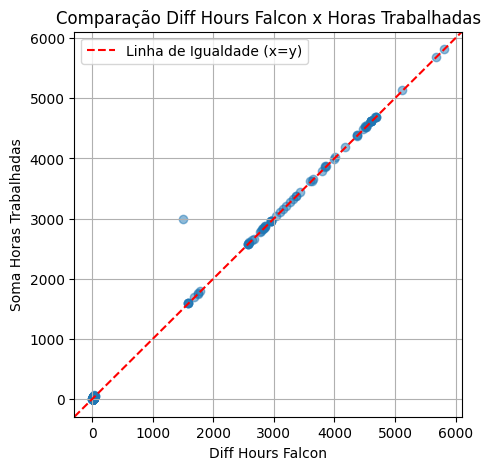

,mes,uf,freight_id,de_type,de_status,vehicle,price,contract_days,diff_hours_falcon,soma_horas_trabalhadas,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado,diferenca_absoluta
13211,2025-01-01,MT,135388,Diária,Finalizada,3/4,1100,5,1494.67,2989.32,10,0,0,0,1494.65


In [33]:
# Gráfico de dispersão para visualizar a relação entre diff_hours_falcon e soma_horas_trabalhadas
plt.figure(figsize=(5,5))
plt.scatter(contratos_inconsistentes['diff_hours_falcon'], contratos_inconsistentes['soma_horas_trabalhadas'], alpha=0.5)
plt.xlabel('Diff Hours Falcon')
plt.ylabel('Soma Horas Trabalhadas')
plt.title('Comparação Diff Hours Falcon x Horas Trabalhadas')
plt.axline((0, 0), slope=1, color='red', linestyle='dashed', label='Linha de Igualdade (x=y)')
plt.legend()
plt.grid(True)
plt.show()

# Identificar o ponto mais extremo onde soma_horas_trabalhadas é muito maior que diff_hours_falcon
base['diferenca_absoluta'] = base['soma_horas_trabalhadas'] - base['diff_hours_falcon']
df_extremo = base[base['diferenca_absoluta'] == base['diferenca_absoluta'].max()]
display(df_extremo)

# exluido extremo da base
base = base.loc[base.freight_id != 135388]

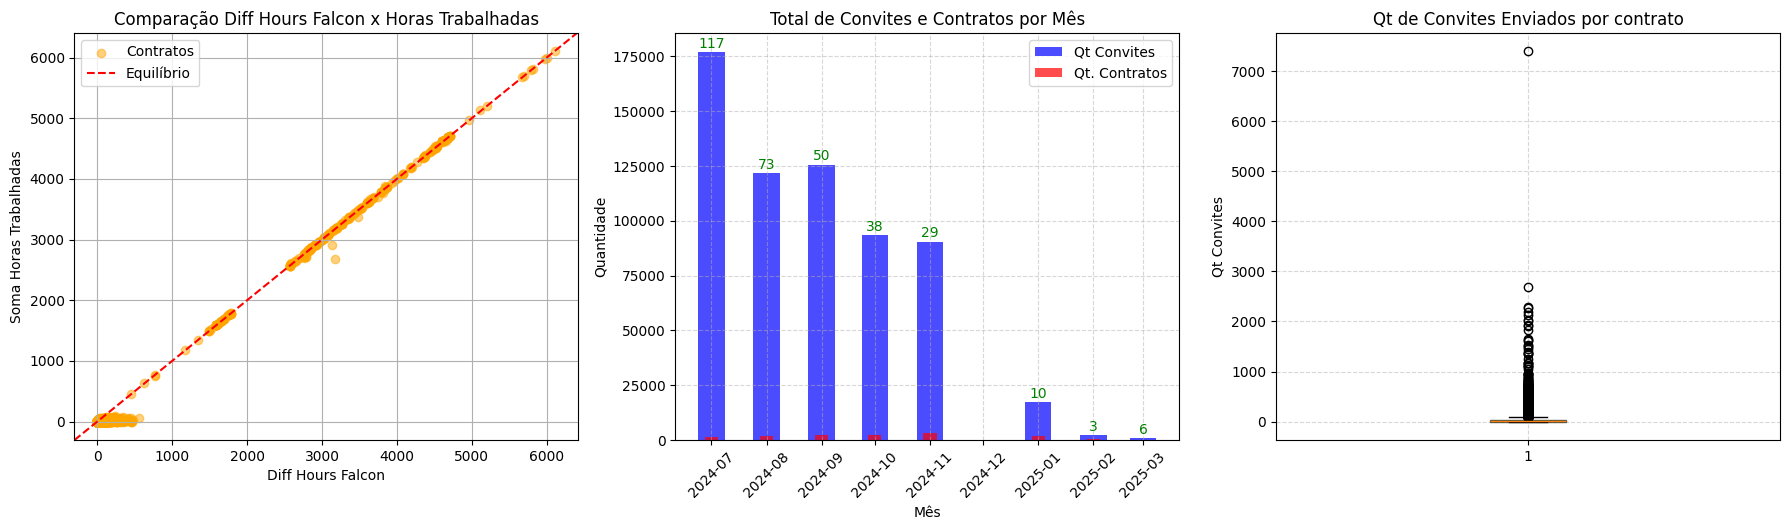

In [34]:
# GRÁFICOS COMPARATIVOS 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico 1: Comparação entre Diff Hours Falcon e Soma Horas Trabalhadas (Mantido)
axes[0].scatter(base['diff_hours_falcon'], base['soma_horas_trabalhadas'], alpha=0.5, color='orange', label='Contratos')
axes[0].set_xlabel('Diff Hours Falcon')
axes[0].set_ylabel('Soma Horas Trabalhadas')
axes[0].set_title('Comparação Diff Hours Falcon x Horas Trabalhadas')
axes[0].axline((0, 0), slope=1, color='red', linestyle='dashed', label='Equilíbrio')
axes[0].legend()
axes[0].grid(True)

# Preparar dados para o gráfico de barras
df_mes = base.groupby('mes').agg({'qt_total_convites': 'sum', 'freight_id': 'count'}).reset_index()

# Calcular a média de convites por contrato
df_mes['convites/contrato'] = df_mes['qt_total_convites'] / df_mes['freight_id']

# Gráfico 2: Qt Total Convites por Mês e Quantidade de Freight_ID (Mantido)
width = 15  

bars1 = axes[1].bar(df_mes['mes'], df_mes['qt_total_convites'], color='blue', alpha=0.7, width=width, label='Qt Convites')
bars2 = axes[1].bar(df_mes['mes'], df_mes['freight_id'], color='red', alpha=0.7, width=width/2, label='Qt. Contratos')

# Adicionar valores da média de convites por contrato no topo das barras azuis
for i, bar in enumerate(bars1):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000, 
                 f"{df_mes['convites/contrato'][i]:.0f}", ha='center', fontsize=10, color='green')

# Ajustar legenda para incluir a explicação da média de convites por contrato
handles, labels = axes[1].get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='green', lw=0, label='convites/contrato'))
axes[1].legend()

axes[1].set_xlabel('Mês')
axes[1].set_ylabel('Quantidade')
axes[1].set_title('Total de Convites e Contratos por Mês')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Gráfico 3: Boxplot da Quantidade Total de Convites (Novo, na cor verde)
axes[2].boxplot(base['qt_total_convites'], vert=True, patch_artist=True, boxprops=dict(facecolor="green", alpha=0.6))
axes[2].set_title('Qt de Convites Enviados por contrato')
axes[2].set_ylabel('Qt Convites')
axes[2].grid(True, linestyle='--', alpha=0.5)

# Ajustar posição das legendas abaixo de cada gráfico
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()


In [41]:
# base_sem_out

base_sem_out = base.copy()
def remove_outliers(base, column):
    Q1 = base_sem_out[column].quantile(0.25)
    Q3 = base_sem_out[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3* IQR
    return base[(base_sem_out[column] >= lower_bound) & (base_sem_out[column] <= upper_bound)]

# Aplicar a remoção de outliers para as colunas críticas
columns_to_clean = ['qt_total_convites', "qt_total_visitas", "diff_hours_falcon",'soma_horas_trabalhadas']

for col in columns_to_clean:
    base_sem_out = remove_outliers(base_sem_out, col)

# elimina contratos em que não houve atuação do time falcon (diff_hours_falcon	soma_horas_trabalhadas	qt_total_convites são todas == 0)
base_sem_out = base_sem_out[~(base_sem_out['diff_hours_falcon'] == 0.00)]
base_sem_out = base_sem_out[~(base_sem_out['soma_horas_trabalhadas'] == 0.00)]

base_sem_out.to_csv('base_sem_out.csv', index=False)

base_sem_out.describe()

,mes,freight_id,price,contract_days,diff_hours_falcon,soma_horas_trabalhadas,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado,diferenca_absoluta,diferenca_percentual
count,9261,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00
mean,2024-10-07 14:46:55.160349952,116887.36,2923.78,9.35,6.83,6.58,18.65,16.20,1.46,0.39,-0.26,4.41
min,2024-07-01 00:00:00,84431.00,80.00,1.00,0.02,0.02,0.00,0.00,0.00,0.00,-30.45,-198.93
25%,2024-09-01 00:00:00,106239.00,372.00,2.00,0.85,0.25,0.00,0.00,0.00,0.00,-0.01,0.00
50%,2024-10-01 00:00:00,116854.00,1365.00,5.00,8.19,8.17,12.00,0.00,0.00,0.00,-0.01,0.12
75%,2024-11-01 00:00:00,124493.00,4270.00,14.00,8.39,8.37,24.00,25.00,2.00,1.00,0.00,2.99
max,2025-03-01 00:00:00,150050.00,36905.00,121.00,30.84,32.33,108.00,112.00,26.00,1.00,16.75,99.93
std,NaN,13776.27,3631.29,10.85,5.26,5.06,23.53,26.33,2.57,0.49,4.13,35.54


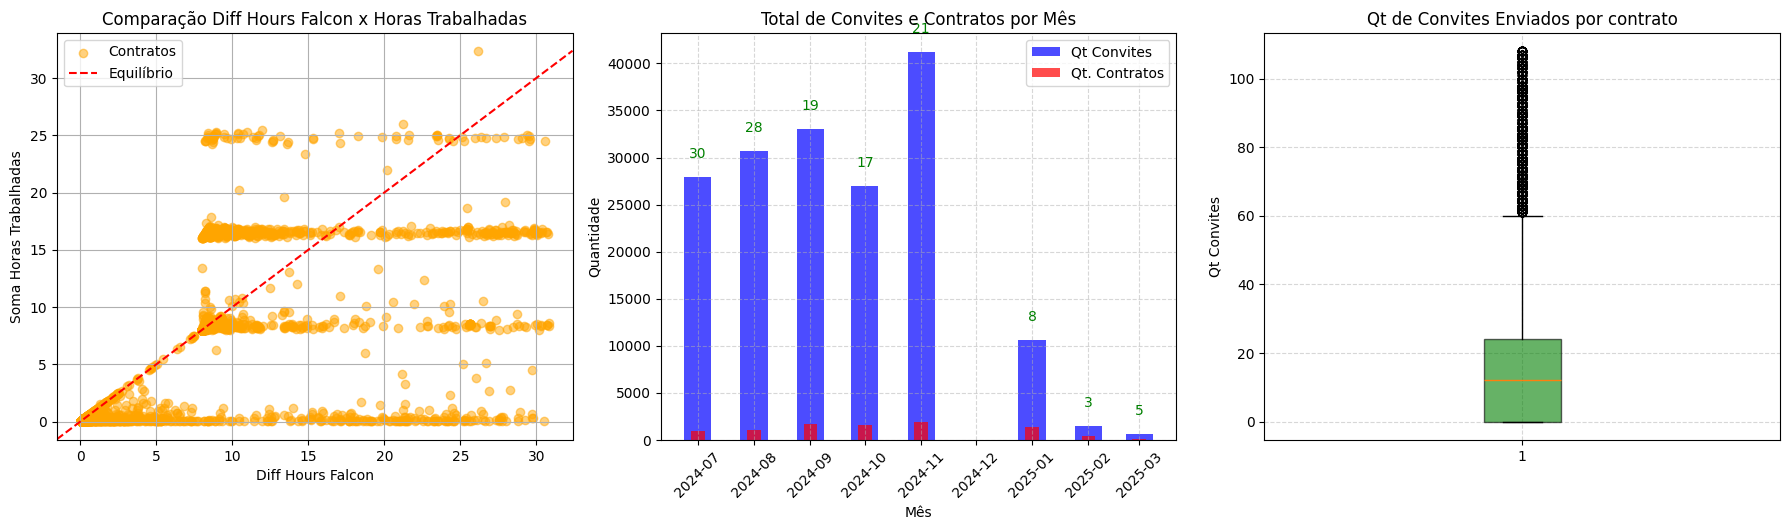

In [42]:
# GRÁFICOS COMPARATIVOS 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico 1: Comparação entre Diff Hours Falcon e Soma Horas Trabalhadas (Mantido)
axes[0].scatter(base_sem_out['diff_hours_falcon'], base_sem_out['soma_horas_trabalhadas'], alpha=0.5, color='orange', label='Contratos')
axes[0].set_xlabel('Diff Hours Falcon')
axes[0].set_ylabel('Soma Horas Trabalhadas')
axes[0].set_title('Comparação Diff Hours Falcon x Horas Trabalhadas')
axes[0].axline((0, 0), slope=1, color='red', linestyle='dashed', label='Equilíbrio')
axes[0].legend()
axes[0].grid(True)

# Preparar dados para o gráfico de barras
df_mes = base_sem_out.groupby('mes').agg({'qt_total_convites': 'sum', 'freight_id': 'count'}).reset_index()

# Calcular a média de convites por contrato
df_mes['convites/contrato'] = df_mes['qt_total_convites'] / df_mes['freight_id']

# Gráfico 2: Qt Total Convites por Mês e Quantidade de Freight_ID (Mantido)
width = 15  

bars1 = axes[1].bar(df_mes['mes'], df_mes['qt_total_convites'], color='blue', alpha=0.7, width=width, label='Qt Convites')
bars2 = axes[1].bar(df_mes['mes'], df_mes['freight_id'], color='red', alpha=0.7, width=width/2, label='Qt. Contratos')

# Adicionar valores da média de convites por contrato no topo das barras azuis
for i, bar in enumerate(bars1):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000, 
                 f"{df_mes['convites/contrato'][i]:.0f}", ha='center', fontsize=10, color='green')

# Ajustar legenda para incluir a explicação da média de convites por contrato
handles, labels = axes[1].get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='green', lw=0, label='convites/contrato'))
axes[1].legend()

axes[1].set_xlabel('Mês')
axes[1].set_ylabel('Quantidade')
axes[1].set_title('Total de Convites e Contratos por Mês')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Gráfico 3: Boxplot da Quantidade Total de Convites (Novo, na cor verde)
axes[2].boxplot(base_sem_out['qt_total_convites'], vert=True, patch_artist=True, boxprops=dict(facecolor="green", alpha=0.6))
axes[2].set_title('Qt de Convites Enviados por contrato')
axes[2].set_ylabel('Qt Convites')
axes[2].grid(True, linestyle='--', alpha=0.5)

# Ajustar posição das legendas abaixo de cada gráfico
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()


In [45]:
import scipy.stats as stats

# Teste t de Student para comparação pareada entre diff_hours_falcon e soma_horas_trabalhadas
t_stat, p_value = stats.ttest_rel(base_sem_out['diff_hours_falcon'], base_sem_out['soma_horas_trabalhadas'])

# Exibir os resultados
print(t_stat, p_value)
print('Existe diferença signtifativa entre a diff_hours_falcon e a soma das horas trabalhadas')

# Calcular a diferença percentual média entre diff_hours_falcon e soma_horas_trabalhadas
base_sem_out['diferenca_percentual'] = ((base_sem_out['diff_hours_falcon'] - base_sem_out['soma_horas_trabalhadas']) / base_sem_out['diff_hours_falcon']) * 100

# Média da diferença percentual
diferenca_percentual_media = base_sem_out['diferenca_percentual'].mean().round(1)

print(f'A diferença percentual média entre diff_hours_falcon e soma_horas_trabalhadas é de aproximadamente {diferenca_percentual_media}%.')

print(f'Isso significa que, em média, o tempo total do Falcon é {diferenca_percentual_media}% maior do que o tempo efetivamente trabalhado. ')

5.944130763868204 2.8797155824742955e-09
Existe diferença signtifativa entre a diff_hours_falcon e a soma das horas trabalhadas
A diferença percentual média entre diff_hours_falcon e soma_horas_trabalhadas é de aproximadamente 4.4%.
Isso significa que, em média, o tempo total do Falcon é 4.4% maior do que o tempo efetivamente trabalhado. 


In [46]:
correlation = base_sem_out[['soma_horas_trabalhadas', 'diff_hours_falcon']].corr().iloc[0, 1]
correlation

0.68013238758078

A correlação de 0.69 entre soma_horas_trabalhadas e diff_hours_falcon indica uma correlação positiva forte/moderada.

✅ Existe uma relação considerável entre as duas variáveis

Quanto maior o tempo diff_hours_falcon, maior tende a ser a soma das horas trabalhadas .

## **2️⃣ Análise de Sucesso de Contratos e Predição de Risco**

## Arrumando base

In [55]:
# base2
base2 = base_sem_out[['mes', 'uf', 'freight_id', 'de_type', 'de_status',
       'vehicle', 'price', 'contract_days', 'qt_total_convites', 'qt_total_visitas',
       'qt_total_candidaturas', 'motorista_selecionado']]
base2.head(3)

,mes,uf,freight_id,de_type,de_status,vehicle,price,contract_days,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado
1,2024-07-01,ES,84431,Coleta/Entrega,Cancelada,Truck,690,3,62,0,0,0
11,2024-07-01,SP,90357,Coleta/Entrega,Cancelada,Vanderleia,4480,16,83,0,0,0
12,2024-07-01,PR,90389,Coleta/Entrega,Cancelada,Truck,230,1,100,0,0,0


In [56]:
base2.describe()

,mes,freight_id,price,contract_days,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado
count,9261,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00
mean,2024-10-07 14:46:55.160349952,116887.36,2923.78,9.35,18.65,16.20,1.46,0.39
min,2024-07-01 00:00:00,84431.00,80.00,1.00,0.00,0.00,0.00,0.00
25%,2024-09-01 00:00:00,106239.00,372.00,2.00,0.00,0.00,0.00,0.00
50%,2024-10-01 00:00:00,116854.00,1365.00,5.00,12.00,0.00,0.00,0.00
75%,2024-11-01 00:00:00,124493.00,4270.00,14.00,24.00,25.00,2.00,1.00
max,2025-03-01 00:00:00,150050.00,36905.00,121.00,108.00,112.00,26.00,1.00
std,NaN,13776.27,3631.29,10.85,23.53,26.33,2.57,0.49


In [57]:
# CÁLCULO DAS TAXAS

# Taxa de visitas por convite
base2['taxa_visitas_por_convite'] = base2['qt_total_visitas'] / base2['qt_total_convites'].replace(0, 1)
base2['taxa_visitas_por_convite'] = (base2['taxa_visitas_por_convite'] - base2['taxa_visitas_por_convite'].min()) / \
                                        (base2['taxa_visitas_por_convite'].max() - base2['taxa_visitas_por_convite'].min())

# Taxa de conversão de visitas em candidaturas
base2['taxa_candidatura_por_visita'] = base2['qt_total_candidaturas'] / base2['qt_total_visitas'].replace(0, 1)
base2['taxa_candidatura_por_visita'] = (base2['taxa_candidatura_por_visita'] - base2['taxa_candidatura_por_visita'].min()) / \
                                    (base2['taxa_candidatura_por_visita'].max() - base2['taxa_candidatura_por_visita'].min())


# Taxa de conversão de visitas em candidaturas
base2['taxa_selecao_por_candidatura'] = base2['motorista_selecionado'] / base2['qt_total_candidaturas'].replace(0, 1)
base2['taxa_selecao_por_candidatura'] = (base2['taxa_selecao_por_candidatura'] - base2['taxa_selecao_por_candidatura'].min()) / \
                                    (base2['taxa_selecao_por_candidatura'].max() - base2['taxa_selecao_por_candidatura'].min())

# Taxa de conversão total (convites até seleção)
base2['taxa_conversao_falcon'] = base2['motorista_selecionado'] / base2['qt_total_convites'].replace(0, 1)
base2['taxa_conversao_falcon'] = (base2['taxa_conversao_falcon'] - base2['taxa_conversao_falcon'].min()) / \
                                    (base2['taxa_conversao_falcon'].max() - base2['taxa_conversao_falcon'].min())

# Taxa de conversão Falcon via multiplicação das taxas
base2['taxa_conversao_falcon_funil'] = base2['taxa_visitas_por_convite'] * base2['taxa_candidatura_por_visita'] * base2['taxa_selecao_por_candidatura']

base2.to_csv('base2.csv', index=False)
base2.head(3)



,mes,uf,freight_id,de_type,de_status,vehicle,price,contract_days,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado,taxa_visitas_por_convite,taxa_candidatura_por_visita,taxa_selecao_por_candidatura,taxa_conversao_falcon,taxa_conversao_falcon_funil
1,2024-07-01,ES,84431,Coleta/Entrega,Cancelada,Truck,690,3,62,0,0,0,0.00,0.00,0.00,0.00,0.00
11,2024-07-01,SP,90357,Coleta/Entrega,Cancelada,Vanderleia,4480,16,83,0,0,0,0.00,0.00,0.00,0.00,0.00
12,2024-07-01,PR,90389,Coleta/Entrega,Cancelada,Truck,230,1,100,0,0,0,0.00,0.00,0.00,0.00,0.00


In [63]:
gargalo_df = base2[['taxa_visitas_por_convite', 'taxa_candidatura_por_visita', 'taxa_selecao_por_candidatura']].mean().reset_index()
gargalo_df.columns = ['Etapa', 'Media_Taxa']
gargalo_df['Media_Taxa_(%)'] = gargalo_df['Media_Taxa'] * 100

gargalo_df

,Etapa,Media_Taxa,Media_Taxa_(%)
0,taxa_visitas_por_convite,0.06,6.40
1,taxa_candidatura_por_visita,0.01,0.74
2,taxa_selecao_por_candidatura,0.20,19.65


Com base na média das taxas de conversão:

- Taxa de Visitas por Convite → 6.4% dos convites resultam em visitas.
- Taxa de Candidatura por Visita → 0.74% das visitas resultam em candidaturas (maior gargalo).
- Taxa de Seleção por Candidatura → 19.6% das candidaturas resultam em motoristas selecionados.

Conclusão
O maior gargalo está na Taxa de Candidatura por Visita, indicando que mesmo quando há visitas, poucos motoristas se candidatam.

Isso pode significar que:

- As oportunidades não são atraentes o suficiente.
- O processo de candidatura pode ter barreiras (tempo, complexidade).
- Os motoristas que visitam não se encaixam nas oportunidades disponíveis.

## Análise de Sucesso de Contratos e Predição de Risco

In [70]:
base2

,mes,uf,freight_id,de_type,de_status,vehicle,price,contract_days,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado,taxa_visitas_por_convite,taxa_candidatura_por_visita,taxa_selecao_por_candidatura,taxa_conversao_falcon,taxa_conversao_falcon_funil
1,2024-07-01,ES,84431,Coleta/Entrega,Cancelada,Truck,690,3,62,0,0,0,0.00,0.00,0.00,0.00,0.00
11,2024-07-01,SP,90357,Coleta/Entrega,Cancelada,Vanderleia,4480,16,83,0,0,0,0.00,0.00,0.00,0.00,0.00
12,2024-07-01,PR,90389,Coleta/Entrega,Cancelada,Truck,230,1,100,0,0,0,0.00,0.00,0.00,0.00,0.00
16,2024-07-01,PR,90546,Diária,Finalizada,Carreta,5280,16,47,0,0,0,0.00,0.00,0.00,0.00,0.00
17,2024-07-01,RS,90600,Ajudante,Cancelada,Nao informado,340,2,0,0,0,0,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14735,2025-03-01,MG,149884,Diária,Carregado,Carreta,3450,10,0,61,5,1,0.54,0.01,0.20,1.00,0.00
14736,2025-03-01,MG,149900,Diária,Carregado,Vanderleia,2188,7,22,4,0,1,0.00,0.00,1.00,0.05,0.00
14737,2025-03-01,SP,149993,Diária,Cancelada,Carreta,2232,6,34,21,4,0,0.01,0.02,0.00,0.00,0.00
14738,2025-03-01,PR,150009,Diária,Cancelada,Carreta,610,2,0,105,4,0,0.94,0.00,0.00,0.00,0.00


In [71]:
# base3 ( ajsutando as variáveis)
from sklearn.preprocessing import LabelEncoder

base3 =base2.copy()
base3 = base2.drop(columns=['mes', 'freight_id', 'de_status'], errors='ignore')


# Codificando variáveis categóricas (estado, tipo de contrato e tipo de veículo)
label_encoders_base3 = {}
categorical_features_base3 = ['uf', 'de_type', 'vehicle']

for feature in categorical_features_base3:
    le = LabelEncoder()
    base3[feature + '_encoded'] = le.fit_transform(base3[feature])
    label_encoders_base3[feature] = le

# Criando a variável-alvo (1 para sucesso, 0 para fracasso)
base3['sucesso_binario'] = base3['motorista_selecionado'].apply(lambda x: 1 if x > 0 else 0)

# base3.to_csv('base3.csv', index=False)
base3.head(3)

,uf,de_type,vehicle,price,contract_days,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado,taxa_visitas_por_convite,taxa_candidatura_por_visita,taxa_selecao_por_candidatura,taxa_conversao_falcon,taxa_conversao_falcon_funil,uf_encoded,de_type_encoded,vehicle_encoded,sucesso_binario
1,ES,Coleta/Entrega,Truck,690,3,62,0,0,0,0.00,0.00,0.00,0.00,0.00,5,1,12,0
11,SP,Coleta/Entrega,Vanderleia,4480,16,83,0,0,0,0.00,0.00,0.00,0.00,0.00,22,1,14,0
12,PR,Coleta/Entrega,Truck,230,1,100,0,0,0,0.00,0.00,0.00,0.00,0.00,15,1,12,0


In [72]:
base3.describe()

,price,contract_days,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado,taxa_visitas_por_convite,taxa_candidatura_por_visita,taxa_selecao_por_candidatura,taxa_conversao_falcon,taxa_conversao_falcon_funil,uf_encoded,de_type_encoded,vehicle_encoded,sucesso_binario
count,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00,9261.00
mean,2923.78,9.35,18.65,16.20,1.46,0.39,0.06,0.01,0.20,0.16,0.00,17.89,1.46,6.35,0.39
std,3631.29,10.85,23.53,26.33,2.57,0.49,0.17,0.02,0.32,0.35,0.00,5.79,0.72,4.04,0.49
min,80.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,372.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,1.00,4.00,0.00
50%,1365.00,5.00,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.00,2.00,4.00,0.00
75%,4270.00,14.00,24.00,25.00,2.00,1.00,0.02,0.01,0.25,0.08,0.00,22.00,2.00,10.00,1.00
max,36905.00,121.00,108.00,112.00,26.00,1.00,1.00,1.00,1.00,1.00,0.00,23.00,2.00,15.00,1.00


In [73]:
base3.sucesso_binario.value_counts()

sucesso_binario
0    5634
1    3627
Name: count, dtype: int64

In [68]:
# Impacto de Estado, Tipo de Contrato e Tipo de Veículo
impacto_estado = base3.groupby('uf')['sucesso_binario'].mean().sort_values() * 100
impacto_tipo_contrato = base3.groupby('de_type')['sucesso_binario'].mean().sort_values() * 100
impacto_veiculo = base3.groupby('vehicle')['sucesso_binario'].mean().sort_values() * 100

print("\nImpacto do Estado no Sucesso do Contrato:\n")
display(impacto_estado)
print("\nImpacto do Tipo de Contrato no Sucesso:\n")
display(impacto_tipo_contrato)
print("\nImpacto do Tipo de Veículo no Sucesso:\n")
display(impacto_veiculo)


Impacto do Estado no Sucesso do Contrato:



uf
AL    0.00
AM    0.00
PB   17.24
MA   27.71
RN   28.57
BA   34.52
PI   36.36
ES   36.49
SC   36.69
RS   37.32
SP   37.97
MT   39.86
MG   39.89
TO   40.00
MS   41.77
CE   43.64
GO   44.24
PE   44.79
PA   44.83
PR   46.19
RJ   46.40
DF   52.00
SE   54.17
RO   71.43
Name: sucesso_binario, dtype: float64


Impacto do Tipo de Contrato no Sucesso:



de_type
Ajudante         21.34
Coleta/Entrega   26.96
Diária           48.70
Name: sucesso_binario, dtype: float64


Impacto do Tipo de Veículo no Sucesso:



vehicle
Tritrem            0.00
Nao informado     21.34
Utilitários       27.27
3/4               30.00
Manobrista        32.91
Romeu e Julieta   33.33
Bitrenzão         34.21
Toco              34.70
Cavalinho         35.59
Bi-Truck          40.47
Vanderleia        40.87
Rodotrem          41.65
Truck             42.93
Carreta           45.42
Ônibus            61.54
Bitrem            62.24
Name: sucesso_binario, dtype: float64

In [74]:


# Criar uma variável combinada para estratificação múltipla (uf + de_type + sucesso_binario)
base3['grupo_estratificado'] = base3['uf'].astype(str) + "_" + base3['de_type'].astype(str) + "_" + base3['sucesso_binario'].astype(str)

#  Remover grupos com poucos registros (<2 amostras) para evitar erro no train_test_split
contagem_grupos = base3['grupo_estratificado'].value_counts()
grupos_insuficientes = contagem_grupos[contagem_grupos < 2].index.tolist()
base3_filtrada = base3[~base3['grupo_estratificado'].isin(grupos_insuficientes)].copy()

# Selecionar as variáveis 
variaveis_corrigidas = ['taxa_candidatura_por_visita', 'taxa_visitas_por_convite','qt_total_candidaturas']

# Criar X (features) e y (variável-alvo)
X_corrigido = base3_filtrada[variaveis_corrigidas]
y_corrigido = base3_filtrada['sucesso_binario']

# Dividir os dados corretamente em treino e teste, garantindo a representatividade por estado e tipo
X_train_corrigido, X_test_corrigido, y_train_corrigido, y_test_corrigido = train_test_split(
    X_corrigido, y_corrigido, test_size=0.5, stratify=base3_filtrada['grupo_estratificado'], random_state=42
)

# reinar o modelo Random Forest s
modelo_corrigido = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_corrigido.fit(X_train_corrigido, y_train_corrigido)

# Fazer previsões no conjunto de teste
y_pred_corrigido = modelo_corrigido.predict(X_test_corrigido)

# Avaliar o modelo e imprimir o relatório
relatorio_corrigido = classification_report(y_test_corrigido, y_pred_corrigido)
print("\n📊 Relatório de Classificação do Modelo Final:\n")
print(relatorio_corrigido)

# Obter as probabilidades previstas pelo modelo
probabilidades = modelo_corrigido.predict_proba(X_test_corrigido)[:, 1]  # Pegando a probabilidade da classe 1 (sucesso)

# Criar um DataFrame com as novas colunas de risco
df_risco_teste = pd.DataFrame({
    "prob_sucesso": probabilidades
}, index=X_test_corrigido.index)  

#  Garantir que os dados de risco sejam corretamente adicionados à base3_filtrada
base3_filtrada.loc[X_test_corrigido.index, "prob_sucesso"] = df_risco_teste["prob_sucesso"]

# Obter a importância das variáveis
importancia_variaveis = pd.DataFrame({'Variável': variaveis_corrigidas, 'Importância': modelo_corrigido.feature_importances_})
importancia_variaveis = importancia_variaveis.sort_values(by='Importância', ascending=False)

# Exibir os fatores mais relevantes
print("\n📊 Fatores mais relevantes para o sucesso de um contrato:\n")
print(importancia_variaveis)

base3_filtrada.head(3)



📊 Relatório de Classificação do Modelo Final:

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2819
           1       0.90      0.95      0.92      1806

    accuracy                           0.94      4625
   macro avg       0.93      0.94      0.94      4625
weighted avg       0.94      0.94      0.94      4625


📊 Fatores mais relevantes para o sucesso de um contrato:

                      Variável  Importância
1     taxa_visitas_por_convite         0.44
0  taxa_candidatura_por_visita         0.33
2        qt_total_candidaturas         0.23


,uf,de_type,vehicle,price,contract_days,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado,taxa_visitas_por_convite,taxa_candidatura_por_visita,taxa_selecao_por_candidatura,taxa_conversao_falcon,taxa_conversao_falcon_funil,uf_encoded,de_type_encoded,vehicle_encoded,sucesso_binario,grupo_estratificado,prob_sucesso
1,ES,Coleta/Entrega,Truck,690,3,62,0,0,0,0.00,0.00,0.00,0.00,0.00,5,1,12,0,ES_Coleta/Entrega_0,NaN
11,SP,Coleta/Entrega,Vanderleia,4480,16,83,0,0,0,0.00,0.00,0.00,0.00,0.00,22,1,14,0,SP_Coleta/Entrega_0,0.00
12,PR,Coleta/Entrega,Truck,230,1,100,0,0,0,0.00,0.00,0.00,0.00,0.00,15,1,12,0,PR_Coleta/Entrega_0,0.00


In [75]:
# risco_uf_type

# Média da probabilidade de sucesso por grupo
media_prob = base3_filtrada.groupby(['uf', 'de_type'])['prob_sucesso'].mean().reset_index()
media_prob.rename(columns={'prob_sucesso': 'media_prob_sucesso'}, inplace=True)
media_prob

,uf,de_type,media_prob_sucesso
0,AL,Ajudante,0.00
1,AL,Coleta/Entrega,0.00
2,AL,Diária,0.00
3,AM,Coleta/Entrega,0.00
4,BA,Ajudante,0.00
...,...,...,...
57,SE,Diária,0.61
58,SP,Ajudante,0.30
59,SP,Coleta/Entrega,0.24
60,SP,Diária,0.46


In [76]:
# Calcular os quartis da coluna 'prob_sucesso' para cada 'de_type'
quartis = media_prob.groupby('de_type')['media_prob_sucesso'].quantile([0.25, 0.75]).unstack()

# Função para classificar risco com base nos quartis
def classificar_risco(media_prob, de_type):
    if pd.isna(media_prob):  # Verifica se é NaN
        return "NaN"
    q1 = quartis.loc[de_type, 0.25] if de_type in quartis.index else None
    q3 = quartis.loc[de_type, 0.75] if de_type in quartis.index else None
    if q1 is None or q3 is None:
        return "NaN"
    elif media_prob < q1:
        return "baixo"
    elif media_prob <= q3:
        return "medio"
    else:
        return "alto"

# Aplicar a classificação no DataFrame
media_prob['classificacao_risco'] = media_prob.apply(lambda row: classificar_risco(row['media_prob_sucesso'], row['de_type']), axis=1)

media_prob

,uf,de_type,media_prob_sucesso,classificacao_risco
0,AL,Ajudante,0.00,medio
1,AL,Coleta/Entrega,0.00,baixo
2,AL,Diária,0.00,baixo
3,AM,Coleta/Entrega,0.00,baixo
4,BA,Ajudante,0.00,medio
...,...,...,...,...
57,SE,Diária,0.61,alto
58,SP,Ajudante,0.30,alto
59,SP,Coleta/Entrega,0.24,medio
60,SP,Diária,0.46,medio


In [77]:
media_prob.classificacao_risco.value_counts()

classificacao_risco
medio    35
alto     16
baixo    11
Name: count, dtype: int64

In [78]:
base4 = base3_filtrada.merge(media_prob, on=['uf', 'de_type'], how='left')
base4.to_csv('base4.csv', index=False)
base4.head(3)

,uf,de_type,vehicle,price,contract_days,qt_total_convites,qt_total_visitas,qt_total_candidaturas,motorista_selecionado,taxa_visitas_por_convite,taxa_candidatura_por_visita,taxa_selecao_por_candidatura,taxa_conversao_falcon,taxa_conversao_falcon_funil,uf_encoded,de_type_encoded,vehicle_encoded,sucesso_binario,grupo_estratificado,prob_sucesso,media_prob_sucesso,classificacao_risco
0,ES,Coleta/Entrega,Truck,690,3,62,0,0,0,0.00,0.00,0.00,0.00,0.00,5,1,12,0,ES_Coleta/Entrega_0,NaN,0.45,alto
1,SP,Coleta/Entrega,Vanderleia,4480,16,83,0,0,0,0.00,0.00,0.00,0.00,0.00,22,1,14,0,SP_Coleta/Entrega_0,0.00,0.24,medio
2,PR,Coleta/Entrega,Truck,230,1,100,0,0,0,0.00,0.00,0.00,0.00,0.00,15,1,12,0,PR_Coleta/Entrega_0,0.00,0.31,medio


# CONTRATOS_FALCON

In [79]:
# df_percent
df_percent = todos_contratos.groupby(['uf', 'de_type']).size().unstack(fill_value=0)
df_percent = df_percent.div(df_percent.sum(axis=1), axis=0) 

# Transformar a tabela para que 'uf' e 'de_type' sejam colunas
df_percent = df_percent.reset_index().melt(id_vars=['uf'], var_name='de_type', value_name='perc_type_estado')
df_percent.head(3)

,uf,de_type,perc_type_estado
0,AC,Ajudante,1.00
1,AL,Ajudante,0.37
2,AM,Ajudante,0.00


In [80]:
# df_merged
df_merged = df_percent.merge(media_prob, on=['uf', 'de_type'], how='inner')

df_merged['sucesso_type_estado'] = df_merged['perc_type_estado'] * df_merged['media_prob_sucesso']
#df_prob_sucesso = df_merged.groupby('uf')['ponderado'].sum().reset_index()
#df_prob_sucesso.rename(columns={'ponderado': 'prob_sucesso'}, inplace=True)
df_merged.head(3)

,uf,de_type,perc_type_estado,media_prob_sucesso,classificacao_risco,sucesso_type_estado
0,AL,Ajudante,0.37,0.00,medio,0.00
1,BA,Ajudante,0.19,0.00,medio,0.00
2,CE,Ajudante,0.23,0.00,medio,0.00


In [81]:
# df_sucesso_estado
df_sucesso_estado = df_merged.groupby('uf')['sucesso_type_estado'].sum().reset_index()

# Renomear a coluna para indicar que é a probabilidade final por estado
df_sucesso_estado.rename(columns={'sucesso_type_estado': 'prob_sucesso_estado'}, inplace=True)
df_sucesso_estado.head(3)


,uf,prob_sucesso_estado
0,AL,0.00
1,AM,0.00
2,BA,0.29


In [82]:
df_sucesso_estado.describe()

,prob_sucesso_estado
count,24.00
mean,0.32
std,0.16
min,0.00
25%,0.29
50%,0.36
75%,0.42
max,0.57


In [92]:
# falcon

# total_falcon
contagem_mensal = base_sem_out.groupby(['mes','de_type', 'uf']).agg(qt_contratos=('freight_id', 'nunique'),).reset_index()
#dias_agenciados_mensal = contratos_falcon.groupby(['mes','dia','categoria', 'meso']).agg(dias_agenciados=('contract_days', 'sum'),).reset_index()

price_mensal = base_sem_out.groupby(['mes','de_type', 'uf']).agg(price =('price', 'sum'),).reset_index()
falcon = contagem_mensal.merge(price_mensal, on=['mes','de_type', 'uf'], how='left').fillna(0)
falcon.head(3)

,mes,de_type,uf,qt_contratos,price
0,2024-07-01,Ajudante,BA,4,1050
1,2024-07-01,Ajudante,GO,8,2500
2,2024-07-01,Ajudante,MA,21,2850


In [93]:
# falcon_meso

falcon_mes = falcon.groupby(["uf", 'de_type'], as_index=False).agg({
    "qt_contratos": "mean",
    "price": "mean",
}).rename(columns={
    "contratos": "media_contratos",
    "price": "media_price",
})

# Calcular a participação percentual de cada categoria dentro de cada mesorregião
# media["participacao_categoria"] = media.groupby("meso")["contratos_media"].transform(lambda x: x / x.sum())

falcon_mes.head(3)

,uf,de_type,qt_contratos,media_price
0,AL,Ajudante,1.33,1993.33
1,AL,Coleta/Entrega,2.00,1886.00
2,AL,Diária,1.00,4880.00


#  BASE PARA DIVISÃO

In [97]:
df_merged

,uf,de_type,perc_type_estado,media_prob_sucesso,classificacao_risco,sucesso_type_estado
0,AL,Ajudante,0.37,0.00,medio,0.00
1,BA,Ajudante,0.19,0.00,medio,0.00
2,CE,Ajudante,0.23,0.00,medio,0.00
3,DF,Ajudante,0.21,0.33,alto,0.07
4,ES,Ajudante,0.14,0.00,medio,0.00
...,...,...,...,...,...,...
57,RS,Diária,0.43,0.52,medio,0.22
58,SC,Diária,0.50,0.56,alto,0.28
59,SE,Diária,0.94,0.61,alto,0.57
60,SP,Diária,0.54,0.46,medio,0.25


In [98]:
# base_divisao

#base_divisao = pd.merge(falcon_meso, clusters_meso, on='meso', how='left')
base_divisao = pd.merge(falcon_mes, df_merged, on=['uf','de_type'], how='left')

base_divisao.to_csv('base_divisao.csv', index=False)

base_divisao = base_divisao[['uf', 'de_type', 'qt_contratos', 'media_price', 'perc_type_estado',
       'media_prob_sucesso', 'classificacao_risco', 'sucesso_type_estado']]
base_divisao.head(3)

,uf,de_type,qt_contratos,media_price,perc_type_estado,media_prob_sucesso,classificacao_risco,sucesso_type_estado
0,AL,Ajudante,1.33,1993.33,0.37,0.00,medio,0.00
1,AL,Coleta/Entrega,2.00,1886.00,0.48,0.00,baixo,0.00
2,AL,Diária,1.00,4880.00,0.16,0.00,baixo,0.00


# distribuir_mesorregioes

In [ ]:
# Função para distribuir mesorregiões de forma equilibrada considerando todas as categorias e clusters
def distribuir_mesoregioes(base_divisao):
    print("Colunas disponíveis no DataFrame:", base_divisao.columns)
    
    # Remover a coluna 'responsavel' existente, se houver
    if 'responsavel' in base_divisao.columns:
        base_divisao = base_divisao.drop(columns=['responsavel'])

    # Calcular a soma total por uf, categoria e cluster
    df_meso_total = base_divisao.groupby(['uf', 'de_type'])['media_contratos'].sum().reset_index()
    
    # Priorizar a distribuição dos clusters na ordem desejada
    cluster_prioridade = [
        'alta atuacao Falcon, risco operacional',
        'alta retencao, muitos contratos, medio atendimento',
        'baixa retencao, poucos contratos, alto atendimento'
    ]
    df_meso_total['cluster_prioridade'] = df_meso_total['cluster_nomeado'].map(lambda x: cluster_prioridade.index(x))
    df_meso_total = df_meso_total.sort_values(by=['cluster_prioridade', 'media_contratos'], ascending=[True, False])

    # Inicializar variáveis para distribuição equilibrada dinamicamente
    distribuicao = []
    soma_donega = {'ajudante': 0, 'curta': 0, 'longa': 0}
    soma_leonardo = {'ajudante': 0, 'curta': 0, 'longa': 0}
    meso_responsavel = {}

    # Distribuir mesorregiões priorizando clusters críticos
    for _, row in df_meso_total.iterrows():
        meso = row['meso']
        categoria = row['categoria']
        cluster = row['cluster_nomeado']
        total_contratos = row['media_contratos']

        # Se a mesorregião já tem um responsável atribuído, manter o mesmo responsável
        if meso in meso_responsavel:
            responsavel = meso_responsavel[meso]
        else:
            # Calcular o desvio considerando o equilíbrio das categorias
            desvio_donega = abs((soma_donega[categoria] + total_contratos) - soma_leonardo[categoria])
            desvio_leonardo = abs((soma_leonardo[categoria] + total_contratos) - soma_donega[categoria])

            # Escolher o responsável que minimiza o desvio
            if desvio_donega <= desvio_leonardo:
                responsavel = 'D'
                soma_donega[categoria] += total_contratos
            else:
                responsavel = 'L'
                soma_leonardo[categoria] += total_contratos
            
            # Atribuir o responsável fixo para a mesorregião
            meso_responsavel[meso] = responsavel

        distribuicao.append({
            'meso': meso, 
            'responsavel': responsavel, 
            'cluster_nomeado': cluster, 
            'categoria': categoria, 
            'media_contratos': total_contratos
        })

    # Criar DataFrame com a nova distribuição e manter todas as linhas
    df_distribuicao_final = pd.DataFrame(distribuicao)

    # Ordenar o DataFrame final pelo nome da mesorregião
    df_distribuicao_final = df_distribuicao_final.sort_values(by='meso')

    # Criar crosstabs separados para Donega e Leonardo com valores inteiros
    crosstab_donega = df_distribuicao_final[df_distribuicao_final['responsavel'] == 'D'].pivot_table(
        index='cluster_nomeado', 
        columns='categoria', 
        values='media_contratos', 
        aggfunc='sum', 
        fill_value=0
    ).round().astype(int)

    crosstab_leonardo = df_distribuicao_final[df_distribuicao_final['responsavel'] == 'L'].pivot_table(
        index='cluster_nomeado', 
        columns='categoria', 
        values='media_contratos', 
        aggfunc='sum', 
        fill_value=0
    ).round().astype(int)

    # Exibir os resultados
    print('\nDistribuição Equilibrada das Mesorregiões (Garantindo Responsável Único por Meso):')
    display(df_distribuicao_final)
    print('\nCrosstab de Contratos para Donega (Valores Inteiros):')
    display(crosstab_donega)
    print('\nCrosstab de Contratos para Leonardo (Valores Inteiros):')
    display(crosstab_leonardo)

    return df_distribuicao_final, crosstab_donega, crosstab_leonardo

# Executar a função com a base fornecida
distribuindo, crosstab_donega, crosstab_leonardo = distribuir_mesoregioes(base_divisao)


In [ ]:
tabela_distribuicao = distribuindo
# Converter media_contratos para inteiro
tabela_distribuicao['media_contratos'] = tabela_distribuicao['media_contratos'].round().astype(int)

# Transformar a coluna 'categoria' em colunas individuais e renomear as colunas
tabela_distribuicao = tabela_distribuicao.pivot_table(index=['meso', 'responsavel', 'cluster_nomeado'],
                          columns='categoria',
                          values='media_contratos',
                          fill_value=0).reset_index()

# Renomear as colunas conforme solicitado
tabela_distribuicao = tabela_distribuicao.rename(columns={
    'ajudante': 'qt_contratos_ajudantes',
    'curta': 'qt_contratos_curta',
    'longa': 'qt_contratos_longa'
})

tabela_distribuicao = tabela_distribuicao.sort_values(
    by=['cluster_nomeado', 'qt_contratos_ajudantes', 'qt_contratos_curta', 'qt_contratos_longa'],
    ascending=[True, True, True, True]
)
pd.set_option('display.max_rows', 110)
tabela_distribuicao


In [ ]:
resumo_distribuindo = distribuindo[['meso','responsavel', 'cluster_nomeado']].drop_duplicates()

grafico_divisao = pd.merge(resumo_distribuindo, ibge_meso, on='meso', how='left')
grafico_divisao

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from geobr import read_state

# Converter o DataFrame em um GeoDataFrame usando a coluna correta de geometria
distribuindo = gpd.GeoDataFrame(grafico_divisao, geometry='geometry_meso')

# Definir uma paleta de cores mais harmoniosa para os clusters
cores_clusters = {
    'alta atuacao Falcon, risco operacional': '#FF6F61',  # Vermelho suave
    'alta retencao, muitos contratos, medio atendimento': '#6B8E23',  # Verde oliva
    'baixa retencao, poucos contratos, alto atendimento': '#4682B4'  # Azul suave
}

# Mapear as cores no DataFrame
distribuindo['cor_cluster'] = distribuindo['cluster_nomeado'].map(cores_clusters)

# Carregar o contorno dos estados do Brasil usando geobr
states_gdf = read_state(year=2020)

# Criar o mapa
fig, ax = plt.subplots(figsize=(14, 12))

# Plotar as mesorregiões coloridas pelo cluster com contorno branco
distribuindo.plot(
    ax=ax, 
    color=distribuindo['cor_cluster'], 
    edgecolor='white', 
    linewidth=0.8,
    zorder=2  # Mesorregiões em camada inferior ao contorno do Brasil
)

# Adicionar as letras dos responsáveis (D/L) no centro das mesorregiões
for idx, row in distribuindo.iterrows():
    if row['geometry_meso'].centroid.is_valid:
        plt.text(
            row['geometry_meso'].centroid.x, 
            row['geometry_meso'].centroid.y, 
            row['responsavel'],
            fontsize=9,
            ha='center', 
            va='center',
            color='black',
            fontweight='bold',
            zorder=3  # Garantir que o texto fique acima do mapa
        )

# Adicionar o contorno do Brasil e dos estados com destaque
states_gdf.boundary.plot(ax=ax, color='black', linewidth=1.5, zorder=4)

# Criar uma legenda personalizada para os clusters
legendas = [
    Patch(facecolor=color, edgecolor='k', label=label) 
    for label, color in cores_clusters.items()
]

# Exibir a legenda no mapa
plt.legend(handles=legendas, title='Clusters', loc='lower left', fontsize=10, title_fontsize=12)

# Título e ajustes
plt.title('Mapa das Mesorregiões do Brasil por Cluster e Responsável', fontsize=16, pad=20)
plt.axis('off')

# Melhorar o layout do mapa
plt.tight_layout()

# Exibir o mapa final
plt.show()


# CENÁRIOS OCULTOS

In [ ]:
contratos_atendidos_falcon = contratos.loc[contratos.atuacao_falcon == 'sim']
taxa_atendimento_falcon_sim = (
    contratos_atendidos_falcon.groupby(['meso'])['foi_cancelada']
    .apply(lambda x: (x == 'nao').sum() / x.count())
    .reset_index(name='taxa_atendimento_falcon_sim'))
display(taxa_atendimento_falcon_sim)

contratos_nao_atendidos_falcon = contratos.loc[contratos.atuacao_falcon == 'nao']
taxa_atendimento_falcon_nao = (
    contratos_nao_atendidos_falcon.groupby(['meso'])['foi_cancelada']
    .apply(lambda x: (x == 'nao').sum() / x.count())
    .reset_index(name='taxa_atendimento_falcon_nao'))
display(taxa_atendimento_falcon_nao)

In [ ]:
comparativo = pd.merge(taxa_atendimento_falcon_nao, taxa_atendimento_falcon_sim, on=['meso'], how='left')

comparativo.fillna(0.00, inplace=True)

# Remover linhas onde ambas as colunas são 0.00 (equivalente a NaN original)
comparativo = comparativo[
    ~((comparativo['taxa_atendimento_falcon_nao'] == 0.00) & 
      (comparativo['taxa_atendimento_falcon_sim'] == 0.00))]



comparativo

In [ ]:
from scipy import stats

# Realizar o teste de Wilcoxon (não paramétrico)
w_stat, p_value_wilcoxon = stats.wilcoxon(
    comparativo['taxa_atendimento_falcon_nao'], 
    comparativo['taxa_atendimento_falcon_sim']
)

print(f"Teste de Wilcoxon: Estatística W = {w_stat:.4f}, p-valor = {p_value_wilcoxon:.4f}")

# Interpretar o resultado
if p_value_wilcoxon < 0.05:
    print("Resultado: Existe uma diferença estatisticamente significativa entre os grupos (Teste de Wilcoxon).")
else:
    print("Resultado: Não há diferença estatisticamente significativa entre os grupos (Teste de Wilcoxon).")


In [ ]:
# Calcular a média das taxas de atendimento para os grupos Falcon Sim e Falcon Não
media_taxa_atendimento = comparativo[['taxa_atendimento_falcon_nao', 'taxa_atendimento_falcon_sim']].mean()

# Exibir o resultado
print("Média das Taxas de Atendimento:")
print(f"Falcon Não: {media_taxa_atendimento['taxa_atendimento_falcon_nao']:.2f}")
print(f"Falcon Sim: {media_taxa_atendimento['taxa_atendimento_falcon_sim']:.2f}")

# Cálculo da diferença percentual
diferenca_percentual = (media_taxa_atendimento['taxa_atendimento_falcon_nao'] - media_taxa_atendimento['taxa_atendimento_falcon_sim']) / media_taxa_atendimento['taxa_atendimento_falcon_sim'] * 100

# Exibir a mensagem formatada
print(f"As mesorregiões onde não houve atuação do Falcon apresentam taxas de atendimento significativamente maiores,")
print(f"com uma diferença de {diferenca_percentual:.2f}% em relação às regiões onde o Falcon atuou.")

# GRAFICOS PARA APRESENTAÇÃO

In [ ]:

graficos = pd.merge(falcon_meso, ibge_meso, on='meso', how='left')
graficos

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from geobr import read_state
from matplotlib.colors import LinearSegmentedColormap

# Carregar o contorno dos estados do Brasil usando geobr
states_gdf = read_state(year=2020)

# Definir categorias e métricas para o mapa de calor
categorias = ['ajudante', 'curta', 'longa']
metricas = ['media_contratos', 'media_price']

# Criar o mapa de calor para cada categoria e métrica
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12), constrained_layout=True)

# Paleta de cores para os mapas de calor
cmap_contratos = LinearSegmentedColormap.from_list('contratos', ['#e0f7fa', '#006064'])
cmap_price = LinearSegmentedColormap.from_list('price', ['#ffebee', '#b71c1c'])

# Iterar sobre as categorias e métricas para criar os gráficos
for row, categoria in enumerate(categorias):
    for col, metrica in enumerate(metricas):
        ax = axes[row, col]
        
        # Filtrar os dados para a categoria específica
        df_categoria = graficos[graficos['categoria'] == categoria]
        
        # Converter o DataFrame em um GeoDataFrame, assegurando a coluna de geometria
        gdf_categoria = gpd.GeoDataFrame(df_categoria, geometry='geometry_meso')
        
        # Escolher o mapa de cores de acordo com a métrica
        cmap = cmap_contratos if metrica == 'media_contratos' else cmap_price
        
        # Plotar o mapa de calor das mesorregiões
        gdf_categoria.plot(
            ax=ax,
            column=metrica,
            cmap=cmap,
            edgecolor='black',
            linewidth=0.5,
            legend=True,
            legend_kwds={'shrink': 0.6, 'label': f'{metrica}'}
        )
        
        # Adicionar o contorno dos estados brasileiros
        states_gdf.boundary.plot(ax=ax, color='black', linewidth=1.2, zorder=4)
        
        # Título do gráfico
        ax.set_title(f'Categoria: {categoria.capitalize()} - {metrica.replace("_", " ").capitalize()}', fontsize=12)

        # Remover eixos para um visual mais limpo
        ax.set_axis_off()

# Título geral do painel de mapas
fig.suptitle('Mapas de Calor por Categoria e Métrica', fontsize=16, y=1.02)

# Exibir o painel de mapas
plt.show()
